In [2]:
import pandas as pd # para manejar los datos
import numpy as np # para operaciones numéricas
from sklearn.preprocessing import StandardScaler # escalado de características
from scipy.spatial.distance import cdist # cálculo de distancias
import matplotlib.pyplot as plt # para visualizaciones

# Cargar datasets de entrenamiento y test
datosTrain = pd.read_csv("../datos-estadistica/X_train.csv", header=0)
datosTest = pd.read_csv("../datos-estadistica/X_test.csv", header=0)

# Normalizar los datos
normalizador = StandardScaler()
trainNormalizado = normalizador.fit_transform(datosTrain.drop('City', axis=1, inplace=False))
testNormalizado = normalizador.fit_transform(datosTest.drop('City', axis=1, inplace=False))

# Inicializa los puntos centrales aleatorios
def inicializarPuntos(df, numPuntos):
    return df[np.random.choice(df.shape[0], numPuntos, replace=False)]

# Asigna cada dato al centroide más cercano
def asignarGrupos(df, puntosCentrales):
    distanciasPuntos = cdist(df, puntosCentrales, 'euclidean')
    return np.argmin(distanciasPuntos, axis=1)

# Actualiza los centroides basándose en la media de los puntos asignados
def recalcularCentros(df, etiquetas, numPuntos):
    nuevosCentros = np.zeros((numPuntos, df.shape[1]))
    for i in range(numPuntos):
        puntosAsignados = df[etiquetas == i]
        nuevosCentros[i, :] = puntosAsignados.mean(axis=0)
    return nuevosCentros

# Implementación del algoritmo K-means
def aplicarKMeans(df, numClusters, iterMax=6, tolerancia=1e-5):
    puntosCentrales = inicializarPuntos(df, numClusters)
    
    for _ in range(iterMax):
        grupos = asignarGrupos(df, puntosCentrales)
        nuevosCentros = recalcularCentros(df, grupos, numClusters)
        
        # Criterio de parada (convergencia)
        if np.all(np.abs(nuevosCentros == puntosCentrales)):
            break
        
        puntosCentrales = nuevosCentros
    
    return puntosCentrales, grupos

# Ejecutar K-means en el conjunto de entrenamiento
k = 6
centroides, gruposAsignados = aplicarKMeans(trainNormalizado, k)
datosTrain['Cluster'] = gruposAsignados
datosTest['Cluster_Pred'] = asignarGrupos(testNormalizado, centroides)


In [3]:
# Función para encontrar la ciudad más cercana en el conjunto de prueba
def buscarCiudadCercana(testNormalizado, datosTrain, datosTest, normalizador):
    ciudadesVecinas = []
    
    for i, fila in datosTest.iterrows():
        clusterAsignado = fila['Cluster_Pred']
        
        # Filtrar las ciudades del mismo cluster
        ciudadesCluster = datosTrain[datosTrain['Cluster'] == clusterAsignado]
        
        # Escalar las ciudades seleccionadas usando el normalizador
        ciudadesEscaladas = normalizador.transform(ciudadesCluster.drop(['City', 'Cluster'], axis=1))
        
        # Calcular la distancia entre la ciudad de prueba y las ciudades del cluster
        distancias = cdist([testNormalizado[i]], ciudadesEscaladas, 'euclidean')
        
        # Obtener el índice de la ciudad más cercana
        idxCiudadCercana = np.argmin(distancias)
        
        # Extraer el nombre de la ciudad más cercana
        ciudadProxima = ciudadesCluster.iloc[idxCiudadCercana]['City']
        
        ciudadesVecinas.append(ciudadProxima)
    
    return ciudadesVecinas

# Función para asignar la ciudad más cercana a los puntos de prueba
def asignarCiudadesProximas(testNormalizado, datosTrain, datosTest, normalizador):
    ciudadesCercanas = buscarCiudadCercana(testNormalizado, datosTrain, datosTest, normalizador)
    
    # Añadir la ciudad más cercana al dataframe de prueba
    datosTest['CiudadCercana'] = ciudadesCercanas
    return datosTest

# Generar archivo CSV de salida con los resultados
def generarCSVSalida(datosTest):
    resultado = datosTest[['City', 'CiudadCercana']]
    
    # Renombrar columnas para cumplir con el formato de salida
    resultado.columns = ['ID', 'label']
    
    # Guardar los resultados en un archivo CSV
    resultado.to_csv('../submission.csv', index=False)

# Llamar a las funciones
datosTest = asignarCiudadesProximas(testNormalizado, datosTrain, datosTest, normalizador)
generarCSVSalida(datosTest)

In [3]:
df_submission = pd.read_csv('submission.csv')
df_submission.dropna(how='all', inplace=True)  # Elimina filas donde todos los valores sean NaN
df_submission.to_csv('submission.csv', index=False)

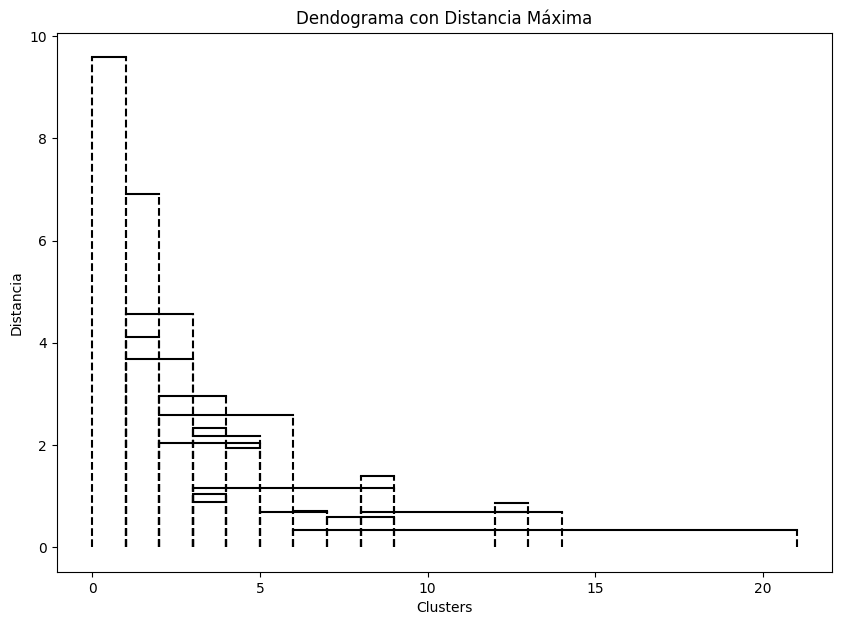

In [4]:
# Cálculo del dendograma con distancia máxima 
def calculate_distance_matrix(data):
    num_samples = data.shape[0]
    distance_matrix = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        for j in range(i+1, num_samples):
            distance = np.linalg.norm(data[i] - data[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
    return distance_matrix

def initialize_clusters(num_samples):
    return [[i] for i in range(num_samples)]

def hierarchical_clustering(distance_matrix, clusters):
    num_samples = distance_matrix.shape[0]
    dendrogram = []
    while len(clusters) > 1:
        min_distance = float('inf')
        merge_pair = None

        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                distance = max([distance_matrix[p1, p2] for p1 in clusters[i] for p2 in clusters[j]])
                if distance < min_distance:
                    min_distance = distance
                    merge_pair = (i, j)

        cluster1, cluster2 = merge_pair
        new_cluster = clusters[cluster1] + clusters[cluster2]
        clusters = [clusters[i] for i in range(len(clusters)) if i not in merge_pair]
        clusters.append(new_cluster)
        
        dendrogram.append((cluster1, cluster2, min_distance))
        
    return dendrogram

def plot_dendrogram(dendrogram, num_samples):
    plt.figure(figsize=(10, 7))
    heights = [x[2] for x in dendrogram]
    for i, (c1, c2, height) in enumerate(dendrogram):
        plt.plot([c1, c2], [height, height], 'k-')
        plt.plot([c1, c1], [0, height], 'k--')
        plt.plot([c2, c2], [0, height], 'k--')
    plt.title('Dendograma con Distancia Máxima')
    plt.xlabel('Clusters')
    plt.ylabel('Distancia')
    plt.show()

# Cálculos
distance_matrix = calculate_distance_matrix(trainNormalizado)
clusters = initialize_clusters(trainNormalizado.shape[0])
dendrogram = hierarchical_clustering(distance_matrix, clusters)
plot_dendrogram(dendrogram, trainNormalizado.shape[0])

In [5]:
# Ruta al archivo Excel de todos los datos 
ruta_archivo = "../datos-estadistica/datos.xlsx"

# Leer el archivo Excel
df = pd.read_excel(ruta_archivo)

data = df[['GDP (USD Billion)', 'Population (Millions)']].values
# Normalizar los datos
def normalize_data(data):
    n = len(data)
    means = [sum(row[i] for row in data) / n for i in range(len(data[0]))]
    std_devs = [((sum((row[i] - means[i]) ** 2 for row in data) / n) ** 0.5) for i in range(len(data[0]))]
    normalized = [[(row[i] - means[i]) / std_devs[i] for i in range(len(row))] for row in data]
    return normalized, means, std_devs

data_normalized, mean, std_dev = normalize_data(data)

In [6]:
def compute_covariance_matrix(data):
    n = len(data)
    m = len(data[0])
    cov_matrix = [[0] * m for _ in range(m)]
    for i in range(m):
        for j in range(m):
            cov_matrix[i][j] = sum(data[k][i] * data[k][j] for k in range(n)) / (n - 1)
    return cov_matrix

cov_matrix = compute_covariance_matrix(data_normalized)
print("Matriz de Covarianza:")
for row in cov_matrix:
    print(row)

Matriz de Covarianza:
[1.0344827586206895, 1.0246659968794567]
[1.0246659968794567, 1.0344827586206895]


In [7]:
#Calcular Eigenvalues y Eigenvectors
def power_method(matrix, num_iterations=1000, tolerance=1e-6):
    n = len(matrix)
    b = [1] * n
    for _ in range(num_iterations):
        # Multiplicación de la matriz por b
        b_next = [sum(matrix[i][j] * b[j] for j in range(n)) for i in range(n)]
        norm = sum(x ** 2 for x in b_next) ** 0.5
        b_next = [x / norm for x in b_next]
        # Verificar convergencia
        if sum(abs(b_next[i] - b[i]) for i in range(n)) < tolerance:
            break
        b = b_next
    eigenvalue = sum(b[i] * sum(matrix[i][j] * b[j] for j in range(n)) for i in range(n))
    return eigenvalue, b

def compute_eigenvalues_and_eigenvectors(matrix):
    n = len(matrix)
    eigenvalues = []
    eigenvectors = []
    for _ in range(n):
        eigenvalue, eigenvector = power_method(matrix)
        eigenvalues.append(eigenvalue)
        eigenvectors.append(eigenvector)
        # Deflacionar la matriz
        matrix = [[matrix[i][j] - eigenvalue * eigenvector[i] * eigenvector[j] for j in range(n)] for i in range(n)]
    return eigenvalues, eigenvectors

eigenvalues, eigenvectors = compute_eigenvalues_and_eigenvectors(cov_matrix)
print("Eigenvalues:\n", eigenvalues)
print("Eigenvectors:\n", eigenvectors)


Eigenvalues:
 [2.059148755500146, 6.660626602072578e-16]
Eigenvectors:
 [[0.7071067811865475, 0.7071067811865475], [0.7071067811865476, 0.7071067811865476]]


In [8]:
#Calcular la Varianza Explicada por el Eigenvalue
def variance_explained(eigenvalues):
    total_variance = sum(eigenvalues)
    return [eigenvalue / total_variance for eigenvalue in eigenvalues]

explained_variance_ratio = variance_explained(eigenvalues)
print("Varianza Explicada por el Eigenvalue:\n", explained_variance_ratio)


Varianza Explicada por el Eigenvalue:
 [0.9999999999999998, 3.234650524534241e-16]


In [9]:
#Obtener el Eigenvector Principal
def get_principal_eigenvector(eigenvalues, eigenvectors):
    max_index = eigenvalues.index(max(eigenvalues))
    return eigenvectors[max_index]

principal_eigenvector = get_principal_eigenvector(eigenvalues, eigenvectors)
print("Valor del Eigenvector Principal:\n", principal_eigenvector)


Valor del Eigenvector Principal:
 [0.7071067811865475, 0.7071067811865475]


In [10]:
#Calcular la Matriz Proyectada
def project_data(data_normalized, principal_eigenvector):
    return [sum(row[i] * principal_eigenvector[i] for i in range(len(row))) for row in data_normalized]

data_pca = project_data(data_normalized, principal_eigenvector)
print("Matriz Proyectada:\n", data_pca)


Matriz Proyectada:
 [6.850254902970839, 2.2542914886585734, 1.289860705902846, 0.5559990515941917, 0.22215487242440524, -0.22552843029010897, -0.28371492170438956, -0.33878373663741, -0.3124044862854518, -0.349819854129487, -0.33577783268351447, -0.35363312033553873, -0.42826201546057013, -0.44611730311259434, -0.46928880894761804, -0.4835326709566296, -0.5067041767916534, -0.5368966933496633, -0.5334871082696897, -0.58855592320271, -0.6187484397607199, -0.5851463381227364, -0.6419199455957436, -0.6740190952567795, -0.6776305208997921, -0.13264056638697524, -0.11640000323926344, -0.24950729837728886, -0.6544590150647684, -0.629582716689758]


In [11]:
def reconstruct_data(projected_data, principal_eigenvector):
    # Reconstrucción
    reconstructed_data = []
    for proj in projected_data:
        recon = [proj * eig for eig in principal_eigenvector]
        reconstructed_data.append(recon)
    return reconstructed_data

In [12]:
# error en la recontruccion
def reconstruction_error(original_data, reconstructed_data):
    error = sum(sum((orig - recon) ** 2 for orig, recon in zip(orig_row, recon_row)) for orig_row, recon_row in zip(original_data, reconstructed_data))
    return error

data_pca = project_data(data_normalized, principal_eigenvector)
reconstructed_data = reconstruct_data(data_pca, principal_eigenvector)
error = reconstruction_error(data_normalized, reconstructed_data)

print("Error de Reconstrucción:\n", error)

Error de Reconstrucción:
 0.2846860904957457


In [61]:
def reconstruction_error_percentage(original_data, reconstructed_data):
    # Calcular el error de reconstrucción
    error_total = reconstruction_error(original_data, reconstructed_data)


    data_longitud = len(original_data)
    # Calcular la varianza total de los datos originales
    total_variance = sum(sum(orig ** 2 for orig in orig_row) for orig_row in original_data)/data_longitud
    print("varia", total_variance)
    # Calcular el error en porcentaje
    error_percentage = (error_total / total_variance) * 100
    return error_percentage

error_percentaje = reconstruction_error_percentage(data_normalized, reconstructed_data)
print("error en porcentaje",round(error_percentaje,3),"%")

varia 1.9999999999999996
error en porcentaje 14.234 %


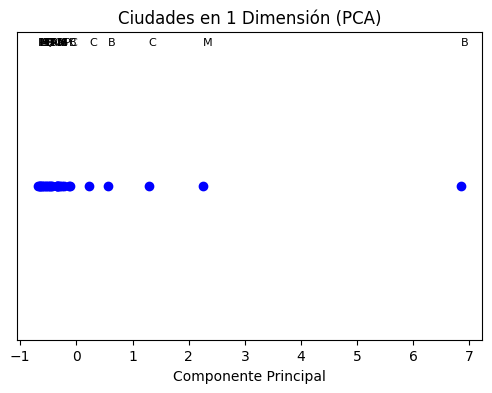

In [13]:
#pintar en una dimension
city_names = df['City'].values 
def plot_1d(data_pca, city_names):
    """Pinta los datos proyectados en 1D."""
    plt.figure(figsize=(6, 4))
    plt.scatter(data_pca, [0] * len(data_pca), c='blue', marker='o')
    for i, city in enumerate(city_names):
        plt.text(data_pca[i], 0.05, city[0], fontsize=8)
    plt.title("Ciudades en 1 Dimensión (PCA)")
    plt.xlabel("Componente Principal")
    plt.yticks([])
    plt.show()

plot_1d(data_pca,city_names)


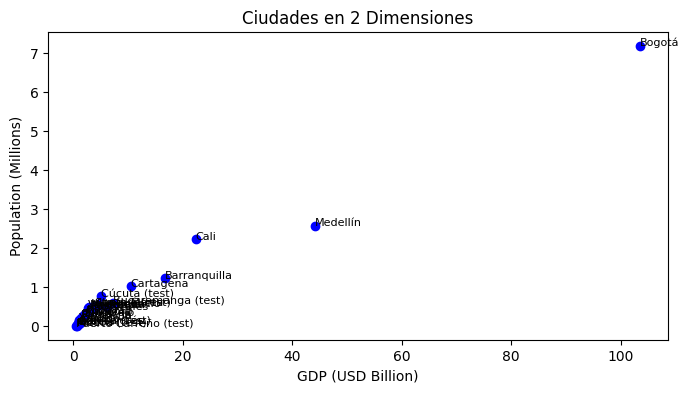

In [15]:
def plot_2d(data, city_names):
    """Pinta los datos originales en 2D."""
    plt.figure(figsize=(8, 4))
    
    # Graficar los puntos
    plt.scatter([row[0] for row in data], [row[1] for row in data], c='blue', marker='o')
    
    # Añadir etiquetas para cada ciudad
    for i, city in enumerate(city_names):
        plt.text(data[i][0], data[i][1], city, fontsize=8)
    
    plt.title("Ciudades en 2 Dimensiones")
    plt.xlabel("GDP (USD Billion)")
    plt.ylabel("Population (Millions)")
    plt.show()

# Suposición: 'data' contiene dos columnas: GDP y Población
# 'city_names' contiene los nombres de las ciudades
plot_2d(data, city_names)
